In [2]:
# Import dependencies
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [3]:
# Ready dataset
train_data = datasets.FashionMNIST(
    root = "data", # where to download the data
    train = True, # do we want the training data?
    download = True, # do we want to download?
    transform = ToTensor(),
    target_transform = None # if we want to transform the labels
)

test_data = datasets.FashionMNIST(
    root = "data", # where to download the data
    train = False, # do we want the training data?
    download = True, # do we want to download?
    transform = ToTensor(),
    target_transform = None # if we want to transform the labels
)

100%|██████████| 26421880/26421880 [00:02<00:00, 11191592.35it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 202988.69it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3766492.45it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10779968.54it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



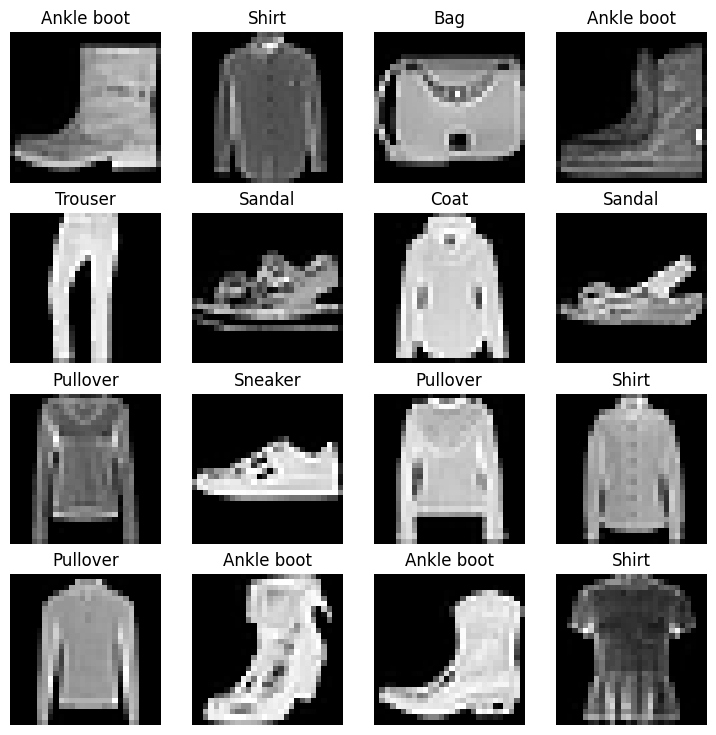

In [4]:
class_names = train_data.classes

# Plot some images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [5]:
# Prepare DataLoader
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                              batch_size = BATCH_SIZE,
                              shuffle = False)

---

### **Building a baseline model first**

---

In [6]:
class FashionMNISTModelV0(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),    # Flattens the data, if it was 5*5 matrix then flattening converts it to 25 size vector
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )
  def forward(self, x):
    return self.layer_stack(x)

In [7]:
torch.manual_seed(42)

model0 = FashionMNISTModelV0(input_shape=784, # this is 28*28 which is the image size
                             hidden_units=8,
                             output_shape=len(class_names)
                             ).to("cpu")

In [8]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("Already exits")
else:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [9]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model0.parameters(), lr=0.1)

In [10]:
# Creating a function to time our experiment
from timeit import default_timer as timer

def print_train_time(start: float, end: float, device: torch.device=None):
  total_time = end-start
  print(f"Train time on {device}: {total_time: .3f} seconds")
  return total_time

In [11]:
# Import tqdm for a progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 4

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n----")

  train_loss = 0

  for batch, (X_train, y_train) in enumerate(train_dataloader):
    model0.train()

    y_pred = model0(X_train)

    loss = loss_fn(y_pred, y_train)
    train_loss += loss

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if batch%400 == 0:
      print(f"Looked at {batch*len(X_train)}/{len(train_dataloader.dataset)} samples.")

  train_loss /= len(train_dataloader)

  test_loss, test_acc = 0, 0
  model0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      test_pred = model0(X_test)

      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"Train loss: {train_loss: .4f} | Test loss: {test_loss: .4f}, Test acc: {test_acc: .4f}")

train_time_end_on_cpu = timer()
total_train_time_model0 = print_train_time(start = train_time_start_on_cpu,
                                           end = train_time_end_on_cpu,
                                           device = str(next(model0.parameters()).device))

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 0
----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss:  0.6046 | Test loss:  0.5061, Test acc:  82.0986
Epoch: 1
----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss:  0.4823 | Test loss:  0.4864, Test acc:  82.8574
Epoch: 2
----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss:  0.4604 | Test loss:  0.4870, Test acc:  83.3167
Epoch: 3
----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.
Train loss:  0.4478 | Test loss:  0.4675, Test acc:  83.6262
Train time on cpu:  37.113 seconds


In [12]:
# Make predictions to evaluate the model0 results
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  """Returns a dictionary containing the results of model predictiong on data_loader."""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      y_pred = model(X)

      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, # only works when model was created with a class
          "model_loss": loss.item(),
          "model_acc": acc}


model0_results = eval_model(model=model0,
                            data_loader=test_dataloader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn)

model0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4674598276615143,
 'model_acc': 83.6261980830671}

---

### **Setup device-agnostic code to run our model on the GPU**

---



In [13]:
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
# Building a better model with non-linearity
class FashionMNISTModelV1(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

In [15]:
torch.manual_seed(42)
model1 = FashionMNISTModelV1(input_shape=784,
                             hidden_units=8,
                             output_shape=len(class_names)).to(device)

In [16]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model1.parameters(), lr=0.1)

In [17]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device:torch.device=device):
  """Performs a training with model trying to learn on data loader."""
  train_loss, train_acc = 0, 0

  model.train()

  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))    # logits -> prediction labels

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  print(f"Train loss: {train_loss: .5f} | Train acc: {train_acc: .2f}%")

In [18]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device=device):
  """Performs a testing step on model going over data loader."""
  test_loss, test_acc = 0, 0

  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)

      loss = loss_fn(y_pred, y)
      test_loss += loss
      test_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))    # logits -> prediction labels

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print(f"Test loss: {test_loss: .5f}, Test acc: {test_acc: .2f}%")

In [19]:
# Creating a function to time our experiment
from timeit import default_timer as timer

def print_train_time(start: float, end: float, device: torch.device=None):
  total_time = end-start
  print(f"Train time on {device}: {total_time: .3f} seconds")
  return total_time

In [20]:
# Import tqdm for a progress bar
from tqdm.auto import tqdm

from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model1.parameters(), lr=0.1)

# Set the seed and start the timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)
train_time_start_on_gpu = timer()

epochs = 4

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n----")

  train_step(model = model1,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             device = device)

  test_step(model = model1,
            data_loader = test_dataloader,
            loss_fn = loss_fn,
            accuracy_fn = accuracy_fn,
            device = device)

train_time_end_on_gpu = timer()
total_train_time_model1 = print_train_time(start = train_time_start_on_gpu,
                                           end = train_time_end_on_gpu,
                                           device = str(next(model1.parameters()).device))

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 0
----
Train loss:  0.91913 | Train acc:  66.24%
Test loss:  0.73198, Test acc:  72.89%
Epoch: 1
----
Train loss:  0.61420 | Train acc:  77.61%
Test loss:  0.50056, Test acc:  81.80%
Epoch: 2
----
Train loss:  0.46734 | Train acc:  83.34%
Test loss:  0.50745, Test acc:  82.43%
Epoch: 3
----
Train loss:  0.45072 | Train acc:  83.89%
Test loss:  0.46860, Test acc:  83.23%
Train time on cuda:0:  41.551 seconds


In [21]:
# Make predictions to evaluate the model results
torch.manual_seed(42)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device=device):
  """Returns a dictionary containing the results of model predictiong on data_loader."""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)

      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, # only works when model was created with a class
          "model_loss": loss.item(),
          "model_acc": acc}

In [22]:
model1_results = eval_model(model = model1,
                            data_loader = test_dataloader,
                            loss_fn = loss_fn,
                            accuracy_fn = accuracy_fn,
                            device = device)
model1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.4685986340045929,
 'model_acc': 83.22683706070288}



---

### **Convolutional Neural Network(CNN)**

---



In [28]:
import torch
from torch import nn

class FashionMNISTModelCNN(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [29]:
torch.manual_seed(42)

model2 = FashionMNISTModelCNN(input_shape = 1,
                              hidden_units = 8,
                              output_shape = len(class_names)).to(device)

In [30]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model2.parameters(), lr=0.1)

In [33]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer

train_time_start_model2 = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-----------------")

  train_step(model = model2,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             device = device)

  test_step(model = model2,
             data_loader = test_dataloader,
             loss_fn = loss_fn,
             accuracy_fn = accuracy_fn,
             device = device)

train_time_end_model2 = timer()
total_train_time_model2 = print_train_time(start = train_time_start_model2,
                                           end = train_time_end_model2,
                                           device = device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----------------
Train loss:  0.26945 | Train acc:  90.27%
Test loss:  0.29636, Test acc:  89.31%
Epoch: 1
-----------------
Train loss:  0.26422 | Train acc:  90.45%
Test loss:  0.29579, Test acc:  89.31%
Epoch: 2
-----------------
Train loss:  0.25926 | Train acc:  90.56%
Test loss:  0.28691, Test acc:  89.83%
Train time on cuda:  36.339 seconds


In [37]:
model2_results = eval_model(
    model = model2,
    data_loader = test_dataloader,
    loss_fn = loss_fn,
    accuracy_fn = accuracy_fn,
    device = device
)

model2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelCNN',
 'model_loss': 0.2869095802307129,
 'model_acc': 89.82627795527156}



---

### **Compare model results**

---



In [42]:
import pandas as pd
compare_results = pd.DataFrame([model0_results, model1_results, model2_results])

# Add training time to results comparison
compare_results["training_time"] = [total_train_time_model0, total_train_time_model1, total_train_time_model2]

compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.467460,83.626198,37.112586
1,FashionMNISTModelV1,0.468599,83.226837,41.550509
2,FashionMNISTModelCNN,0.286910,89.826278,36.339089


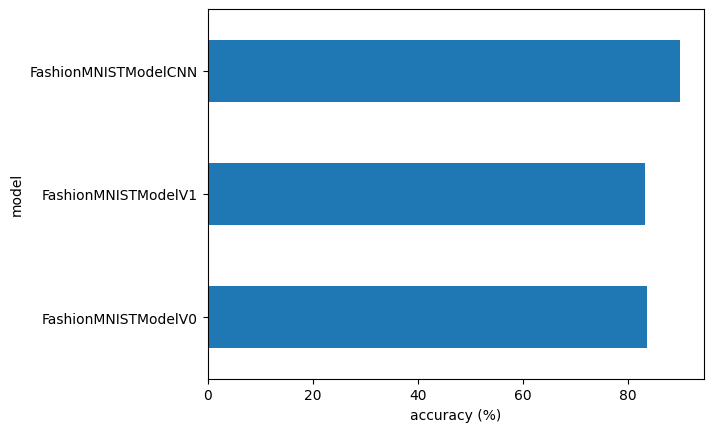

In [43]:
# Visualize out model results using graph
compare_results.set_index("model_name")["model_acc"].plot(kind = "barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")
plt.show()



---

### **Making a confusion matric for further prediction evaluation**

---



In [44]:
from tqdm.auto import tqdm

# Make predictions with trained model

y_preds = []
model2.eval()

with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions...."):
    X, y = X.to(device), y.to(device)
    y_logit = model2(X)
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)

    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions....:   0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
!pip install torchmetrics mlxtend
import torchmetrics, mlxtend

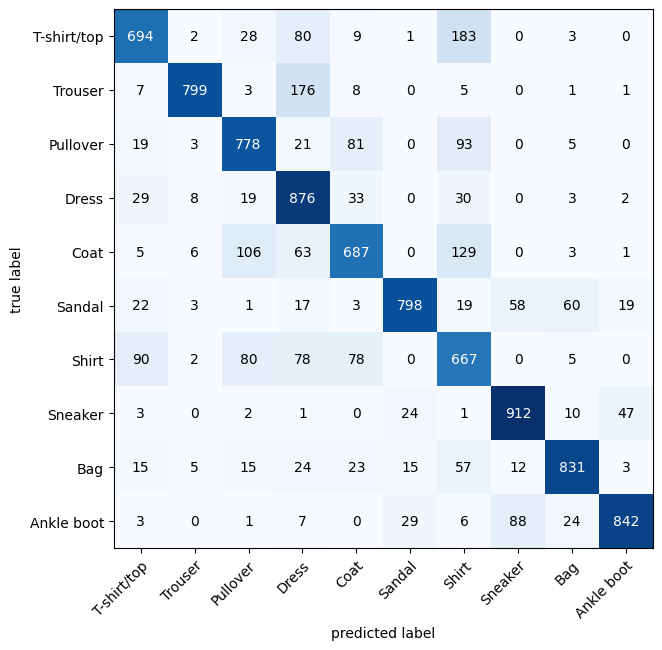

In [53]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task='multiclass', num_classes=len(class_names))
confmat_tensor = confmat(preds = y_pred_tensor, target = test_data.targets)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(), # matplotlib works with numpy
    class_names = class_names,
    figsize = (10, 7)
)



---

### **Save and Load trained model**

---



In [54]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = "3-computer-vision-CNN.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
torch.save(obj=model2.state_dict(), f=MODEL_SAVE_PATH)

In [55]:
# Load the saved model
torch.manual_seed(42)

loaded_model = FashionMNISTModelCNN(input_shape = 1,
                                    hidden_units = 8,
                                    output_shape = len(class_names))

loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model.to(device)

FashionMNISTModelCNN(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=392, out_features=10, bias=True)
  )
)